# LDA Topic Modeling - Komentar YouTube

Notebook ini melakukan topic modeling menggunakan **Latent Dirichlet Allocation (LDA)** pada komentar YouTube untuk menemukan topik-topik utama yang dibahas.

## 1. Install Dependencies

Jalankan cell ini jika belum install library yang dibutuhkan.

In [1]:
!pip install pandas numpy scikit-learn gensim nltk pyLDAvis matplotlib seaborn wordcloud Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 23.2 MB/s eta 0:00:00


## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Indonesian NLP
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.createStemmer()
    USE_STEMMER = True
    print("Sastrawi stemmer loaded successfully!")
except:
    USE_STEMMER = False
    print("Sastrawi not available. Skipping stemming.")

print("All libraries loaded successfully!")

Sastrawi not available. Skipping stemming.
All libraries loaded successfully!


## 3. Load Data

In [3]:
# Load komentar YouTube
df = pd.read_csv('youtube_comments.csv')
print(f"Total komentar: {len(df)}")
print(f"\nKolom: {df.columns.tolist()}")
print(f"\nPreview data:")
df.head()

Total komentar: 11271

Kolom: ['publishedAt', 'authorDisplayName', 'textDisplay', 'likeCount']

Preview data:


,publishedAt,authorDisplayName,textDisplay,likeCount
0,2025-12-09T02:24:10Z,@Nekokun-k8k,Makasih berkat anda gua jadi bodoh amat kemarin,0
1,2025-12-03T16:05:46Z,@joviputr1238,Anak abah CS DAN BANTENG pasti pada emosi 😅 k...,0
2,2025-11-22T18:29:33Z,@rudiumardani5494,Tau enggak china pki....tai china bangsat....b...,0
3,2025-11-22T18:28:20Z,@rudiumardani5494,Harusnya elu susul tuh si atheis LEE KUAN YEW...,0
4,2025-11-20T03:55:24Z,@Bossge1091,Terlalu banyak otak kosong dan terlalu banyak ...,1


In [4]:
# Load stopwords Indonesia (gunakan file yang ada, atau buat daftar default)
try:
    with open('stoplist.txt', 'r', encoding='utf-8') as f:
        stopwords_id = set([line.strip().lower() for line in f.readlines()])
    print(f"Loaded {len(stopwords_id)} stopwords from file")
except:
    # Default Indonesian stopwords
    stopwords_id = set([
        'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'dengan', 'untuk', 'pada',
        'adalah', 'juga', 'tidak', 'akan', 'ada', 'saya', 'kita', 'dia', 'mereka',
        'anda', 'bisa', 'sudah', 'jadi', 'kalau', 'karena', 'aja', 'lagi', 'udah',
        'gak', 'ga', 'gw', 'lu', 'lo', 'nya', 'kan', 'dong', 'deh', 'sih', 'nih',
        'yg', 'gue', 'elo', 'sama', 'tapi', 'atau', 'juga', 'kalau', 'buat', 'kalo',
        'mau', 'lah', 'ya', 'oh', 'ah', 'eh', 'oke', 'ok', 'banget', 'bgt',
        'tau', 'tahu', 'pas', 'waktu', 'banyak', 'semua', 'orang', 'org', 'lebih',
        'cuma', 'hanya', 'masih', 'gimana', 'gmn', 'gitu', 'gitu', 'begitu',
        'sekali', 'bisa', 'emang', 'memang', 'lalu', 'terus', 'kemudian', 'oleh',
        'saat', 'sekarang', 'sebelum', 'sesudah', 'setelah', 'sampai', 'hingga',
        'mana', 'siapa', 'kenapa', 'mengapa', 'kapan', 'dimana', 'bagaimana',
        'berapa', 'apa', 'apakah', 'tersebut', 'seperti', 'sebagai', 'dalam',
        'jika', 'bila', 'maka', 'bagi', 'tentang', 'antara', 'atas', 'bawah',
        'tetapi', 'namun', 'hal', 'cara', 'harus', 'dapat', 'telah', 'belum',
        'pernah', 'kamu', 'kami', 'aku', 'diri', 'sendiri', 'saja', 'doang'
    ])
    print(f"Using {len(stopwords_id)} default Indonesian stopwords")

Loaded 766 stopwords from file


In [5]:
# Load singkatan (jika tersedia)
try:
    singkatan_df = pd.read_csv('singkatan-lib.csv', header=None, names=['singkatan', 'lengkap'])
    singkatan_dict = dict(zip(singkatan_df['singkatan'].str.lower(), singkatan_df['lengkap'].str.lower()))
    print(f"Loaded {len(singkatan_dict)} singkatan")
except:
    singkatan_dict = {
        'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'ngk': 'tidak',
        'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk', 'krn': 'karena',
        'klo': 'kalau', 'kalo': 'kalau', 'tdk': 'tidak', 'blm': 'belum',
        'sdh': 'sudah', 'udh': 'sudah', 'dpt': 'dapat', 'pd': 'pada',
        'gw': 'saya', 'gue': 'saya', 'lu': 'kamu', 'lo': 'kamu',
        'bngt': 'banget', 'bgt': 'banget', 'sm': 'sama', 'tp': 'tapi',
        'jd': 'jadi', 'bs': 'bisa', 'org': 'orang', 'orng': 'orang',
        'gmn': 'gimana', 'skrg': 'sekarang', 'knp': 'kenapa', 'hrs': 'harus'
    }
    print(f"Using {len(singkatan_dict)} default singkatan")

Loaded 175 singkatan


## 4. Text Preprocessing

In [6]:
def clean_text(text):
    """Membersihkan teks dari noise"""
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Hapus HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)

    # Hapus URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Hapus mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Hapus hashtags
    text = re.sub(r'#\w+', '', text)

    # Hapus emoji dan karakter khusus, tapi pertahankan huruf Indonesia
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Hapus multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def expand_singkatan(text, singkatan_dict):
    """Mengubah singkatan menjadi bentuk lengkap"""
    words = text.split()
    expanded = [singkatan_dict.get(word, word) for word in words]
    return ' '.join(expanded)

def remove_stopwords(text, stopwords):
    """Menghapus stopwords"""
    words = text.split()
    filtered = [word for word in words if word not in stopwords and len(word) > 2]
    return ' '.join(filtered)

def stem_text(text):
    """Stemming menggunakan Sastrawi"""
    if USE_STEMMER:
        return stemmer.stem(text)
    return text

def preprocess_text(text, singkatan_dict, stopwords):
    """Pipeline preprocessing lengkap"""
    text = clean_text(text)
    text = expand_singkatan(text, singkatan_dict)
    text = remove_stopwords(text, stopwords)
    text = stem_text(text)
    return text

In [7]:
# Terapkan preprocessing
print("Preprocessing teks...")
df['text_clean'] = df['textDisplay'].apply(lambda x: preprocess_text(x, singkatan_dict, stopwords_id))

# Hapus komentar kosong setelah preprocessing
df = df[df['text_clean'].str.len() > 10].reset_index(drop=True)
print(f"\nKomentar setelah filtering: {len(df)}")

# Tampilkan contoh hasil preprocessing
print("\nContoh hasil preprocessing:")
for i in range(3):
    print(f"\nOriginal: {df['textDisplay'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['text_clean'].iloc[i][:80]}...")

Preprocessing teks...

Komentar setelah filtering: 9903

Contoh hasil preprocessing:

Original: Makasih berkat anda gua jadi bodoh amat kemarin...
Cleaned:  makasih berkat bodoh kemarin...

Original: Anak abah CS DAN BANTENG  pasti pada emosi 😅 karena rencana GAGAL !!!...
Cleaned:  anak abah banteng emosi rencana gagal...

Original: Tau enggak china pki....tai china bangsat....brengsek....gua tumbalin loe china ...
Cleaned:  tau china pki tai china bangsat brengsek tumbalin china babi...


## 5. Prepare Data untuk LDA

In [8]:
# Tokenisasi: pecah teks menjadi list kata
texts = df['text_clean'].tolist()
tokenized_texts = [text.split() for text in texts]

print(f"Total dokumen: {len(tokenized_texts)}")
print(f"Contoh tokenized: {tokenized_texts[0][:10]}")

Total dokumen: 9903
Contoh tokenized: ['makasih', 'berkat', 'bodoh', 'kemarin']


In [9]:
# Buat Dictionary dan Corpus untuk Gensim LDA
dictionary = corpora.Dictionary(tokenized_texts)

# Filter extreme words
# no_below: minimum document frequency
# no_above: maximum document frequency (as fraction)
dictionary.filter_extremes(no_below=5, no_above=0.5)

print(f"Vocabulary size sebelum filtering: {len(corpora.Dictionary(tokenized_texts))}")
print(f"Vocabulary size setelah filtering: {len(dictionary)}")

Vocabulary size sebelum filtering: 17172
Vocabulary size setelah filtering: 3391


In [10]:
# Buat corpus (Bag of Words)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

print(f"Corpus size: {len(corpus)}")
print(f"Contoh BoW untuk dokumen pertama: {corpus[0][:5]}")

Corpus size: 9903
Contoh BoW untuk dokumen pertama: [(0, 1), (1, 1), (2, 1), (3, 1)]


## 6. Mencari Jumlah Topik Optimal

Kita akan menggunakan Coherence Score untuk menentukan jumlah topik yang optimal.

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute coherence values untuk berbagai jumlah topik
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        print(f"Training LDA dengan {num_topics} topik...", end="\r")
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=1,
            passes=10,
            alpha='auto',
            eta='auto'
        )
        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

In [16]:
# Cari jumlah topik optimal (dari 2 sampai 10 topik)
print("Mencari jumlah topik optimal...")

start = 2
limit = 10
step = 1

model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=tokenized_texts,
    start=start,
    limit=limit,
    step=step
)

print("\nSelesai!")

Mencari jumlah topik optimal...



Selesai!


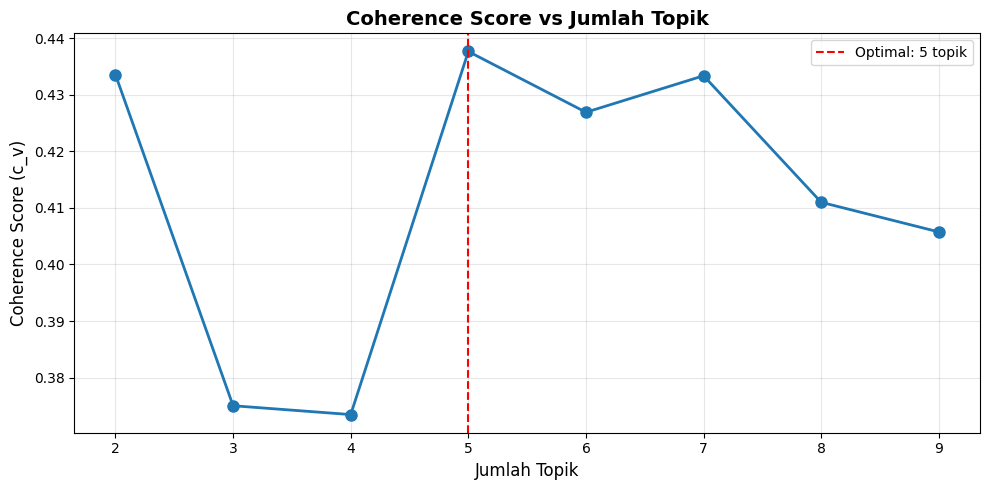


Jumlah topik optimal: 5
Coherence score tertinggi: 0.4376


In [17]:
# Plot coherence scores
x = range(start, limit, step)

plt.figure(figsize=(10, 5))
plt.plot(x, coherence_values, 'o-', linewidth=2, markersize=8)
plt.xlabel("Jumlah Topik", fontsize=12)
plt.ylabel("Coherence Score (c_v)", fontsize=12)
plt.title("Coherence Score vs Jumlah Topik", fontsize=14, fontweight='bold')
plt.xticks(x)
plt.grid(True, alpha=0.3)

# Tandai titik optimal
optimal_idx = np.argmax(coherence_values)
optimal_num_topics = start + optimal_idx * step
plt.axvline(x=optimal_num_topics, color='r', linestyle='--', label=f'Optimal: {optimal_num_topics} topik')
plt.legend()

plt.tight_layout()
plt.savefig('lda_coherence_scores.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nJumlah topik optimal: {optimal_num_topics}")
print(f"Coherence score tertinggi: {coherence_values[optimal_idx]:.4f}")

## 7. Train Model LDA Final

In [18]:
# Gunakan jumlah topik optimal, atau set manual
NUM_TOPICS = optimal_num_topics

print(f"Training LDA model dengan {NUM_TOPICS} topik...")

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=5,
    passes=15,
    alpha='auto',
    eta='auto',
    update_every=1,
    chunksize=100,
    per_word_topics=True
)

print("Model training selesai!")

Training LDA model dengan 5 topik...
Model training selesai!


In [19]:
# Hitung coherence score final
coherence_model = CoherenceModel(
    model=lda_model,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"\nFinal Coherence Score: {coherence_score:.4f}")


Final Coherence Score: 0.3895


## 8. Hasil Topik

In [20]:
# Tampilkan topik-topik yang ditemukan
print("=" * 60)
print("TOPIK-TOPIK YANG DITEMUKAN")
print("=" * 60)

topics = lda_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"\n Topik {idx + 1}:")
    # Parse kata dan bobot
    words = re.findall(r'"(\w+)"', topic)
    weights = re.findall(r'([0-9.]+)\*', topic)
    print(f"   Kata kunci: {', '.join(words)}")

TOPIK-TOPIK YANG DITEMUKAN

 Topik 1:
   Kata kunci: quot, prabowo, aset, bikin, perampasan, oknum, warga, biar, bener, jokowi

 Topik 2:
   Kata kunci: rakyat, pemerintah, negara, presiden, militer, darurat, amp, polisi, partai, pendemo

 Topik 3:
   Kata kunci: tau, dalang, the, hidup, bakar, mati, indo, fokus, kondisi, setuju

 Topik 4:
   Kata kunci: dpr, demo, masyarakat, langsung, stay, akun, safe, anggota, video, terimakasih

 Topik 5:
   Kata kunci: ferry, orang, buzzer, sehat, indonesia, semoga, hati, teman, report, jaga


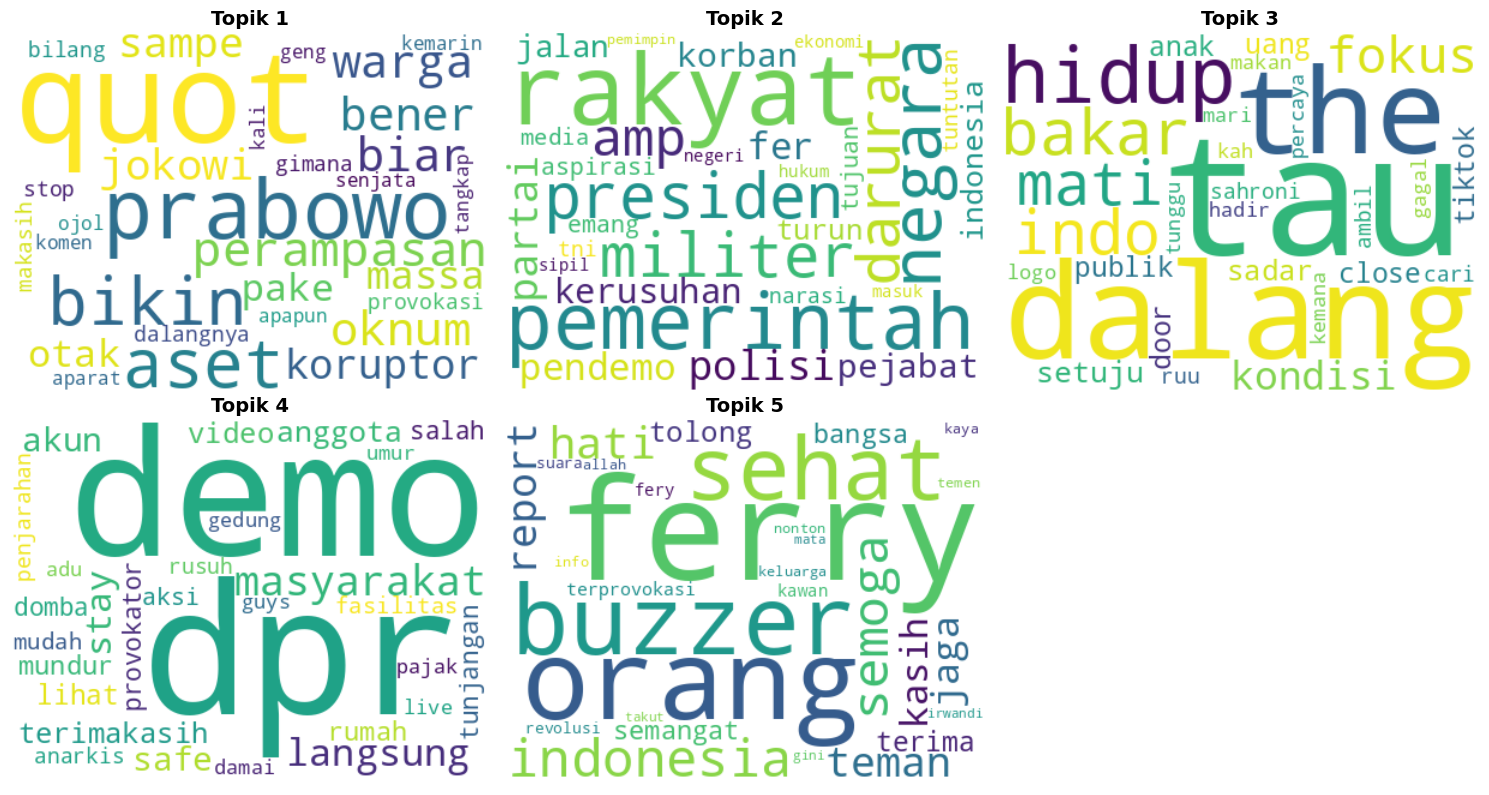

In [21]:
# Visualisasi Word Cloud per Topik
n_cols = min(3, NUM_TOPICS)
n_rows = (NUM_TOPICS + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if NUM_TOPICS > 1 else [axes]

for idx in range(NUM_TOPICS):
    topic_words = dict(lda_model.show_topic(idx, 30))

    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color='white',
        colormap='viridis',
        max_words=30
    ).generate_from_frequencies(topic_words)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Topik {idx + 1}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# Sembunyikan subplot kosong
for idx in range(NUM_TOPICS, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('lda_wordclouds.png', dpi=150, bbox_inches='tight')
plt.show()

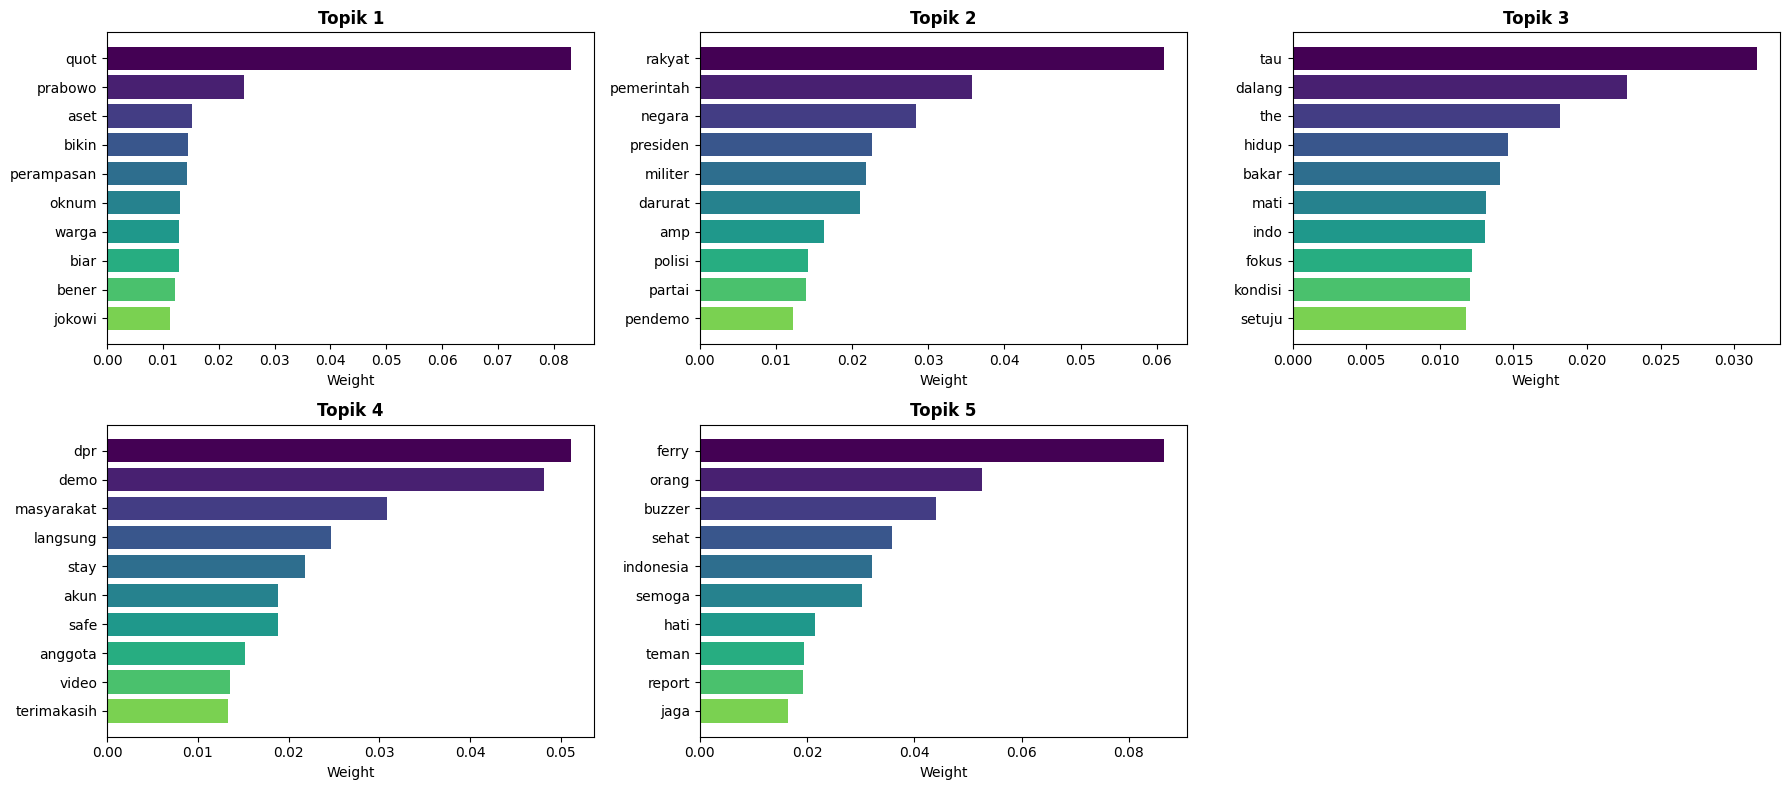

In [22]:
# Visualisasi Weight per Topik (Bar Chart)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten() if NUM_TOPICS > 1 else [axes]

colors = plt.cm.viridis(np.linspace(0, 0.8, 10))

for idx in range(NUM_TOPICS):
    topic_words = lda_model.show_topic(idx, 10)
    words = [w[0] for w in topic_words]
    weights = [w[1] for w in topic_words]

    y_pos = np.arange(len(words))
    axes[idx].barh(y_pos, weights, color=colors)
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(words)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Weight')
    axes[idx].set_title(f'Topik {idx + 1}', fontsize=12, fontweight='bold')

for idx in range(NUM_TOPICS, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('lda_topic_weights.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Assign Topik ke Setiap Dokumen

In [23]:
# Dapatkan topik dominan untuk setiap komentar
def get_dominant_topic(lda_model, corpus, texts):
    """
    Mendapatkan topik dominan untuk setiap dokumen
    """
    dominant_topics = []
    topic_percentages = []

    for i, doc in enumerate(corpus):
        topic_dist = lda_model.get_document_topics(doc)
        if topic_dist:
            dominant_topic = max(topic_dist, key=lambda x: x[1])
            dominant_topics.append(dominant_topic[0] + 1)  # +1 untuk 1-indexed
            topic_percentages.append(dominant_topic[1])
        else:
            dominant_topics.append(0)
            topic_percentages.append(0)

    return dominant_topics, topic_percentages

dominant_topics, topic_probs = get_dominant_topic(lda_model, corpus, tokenized_texts)
df['dominant_topic'] = dominant_topics
df['topic_probability'] = topic_probs

print("Topik berhasil di-assign ke setiap dokumen")

Topik berhasil di-assign ke setiap dokumen


In [24]:
# Distribusi Topik
print("\n" + "=" * 50)
print("DISTRIBUSI TOPIK")
print("=" * 50)

topic_counts = df['dominant_topic'].value_counts().sort_index()
for topic, count in topic_counts.items():
    percentage = (count / len(df)) * 100
    print(f"Topik {topic}: {count} komentar ({percentage:.1f}%)")


DISTRIBUSI TOPIK
Topik 1: 1633 komentar (16.5%)
Topik 2: 2186 komentar (22.1%)
Topik 3: 750 komentar (7.6%)
Topik 4: 2706 komentar (27.3%)
Topik 5: 2628 komentar (26.5%)


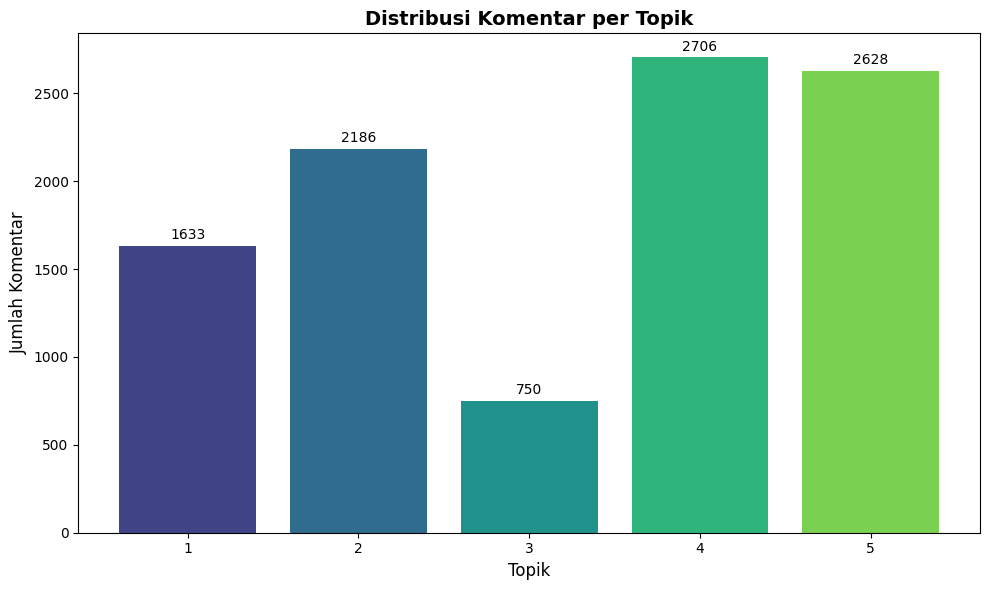

In [25]:
# Visualisasi distribusi topik
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(topic_counts)))
bars = plt.bar(topic_counts.index, topic_counts.values, color=colors)

plt.xlabel('Topik', fontsize=12)
plt.ylabel('Jumlah Komentar', fontsize=12)
plt.title('Distribusi Komentar per Topik', fontsize=14, fontweight='bold')
plt.xticks(topic_counts.index)

# Add value labels
for bar, count in zip(bars, topic_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('lda_topic_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Contoh komentar per topik
print("\n" + "=" * 60)
print("CONTOH KOMENTAR PER TOPIK")
print("=" * 60)

for topic_num in sorted(df['dominant_topic'].unique()):
    if topic_num == 0:
        continue

    print(f"\n TOPIK {topic_num}")
    print("-" * 40)

    # Kata kunci topik
    topic_words = lda_model.show_topic(topic_num - 1, 8)
    keywords = [w[0] for w in topic_words]
    print(f"Kata kunci: {', '.join(keywords)}")
    print()

    # Ambil 3 komentar dengan probability tertinggi
    samples = df[df['dominant_topic'] == topic_num].nlargest(3, 'topic_probability')
    for idx, row in samples.iterrows():
        text = str(row['textDisplay'])[:100]
        prob = row['topic_probability']
        print(f"  [{prob:.2f}] {text}...")


CONTOH KOMENTAR PER TOPIK

 TOPIK 1
----------------------------------------
Kata kunci: quot, prabowo, aset, bikin, perampasan, oknum, warga, biar

  [0.63] Kalau pengadaan proyek penyusunan anggaran terbuka pasti mereka pakai cara penggelembungan anggaran ...
  [0.61] Koruptor sekelas rizha chalid setya novanto dll itu harusnya di tangkap massa, jangan lepasin anak i...
  [0.61] Ahmad Syahroni , Eko Patrio , Uya Kuya , Nafa Urbach , Sri Mulyani Mundur  Miskinkan 😂...

 TOPIK 2
----------------------------------------
Kata kunci: rakyat, pemerintah, negara, presiden, militer, darurat, amp, polisi

  [0.77] dprnya korup krn kerusakan moral rakyat yg bermental budak, aneh rakyat indonesia ini cocoknya jd ra...
  [0.69] Terima kasih atas Informasinya Mas Ferri. Namun alangkah eloknya bila memberikan pengetahuan tidak s...
  [0.68] Tetap kan UU pemiskinan pejabat korup, buat kebijakan yang menguntungkan rakyat bukan menguntungkan ...

 TOPIK 3
----------------------------------------
Kat

## 10. Interactive Visualization (pyLDAvis)

Visualisasi interaktif untuk eksplorasi topik lebih lanjut.

In [27]:
# Visualisasi interaktif dengan pyLDAvis
try:
    import pyLDAvis
    import pyLDAvis.gensim_models as gensimvis

    pyLDAvis.enable_notebook()

    vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

    # Simpan sebagai HTML
    pyLDAvis.save_html(vis_data, 'lda_visualization.html')
    print("Visualisasi interaktif disimpan ke 'lda_visualization.html'")
    print("Buka file tersebut di browser untuk eksplorasi interaktif.")

    # Display di notebook
    display(vis_data)
except ImportError:
    print("pyLDAvis tidak tersedia. Install dengan: pip install pyLDAvis")
except Exception as e:
    print(f"Error creating visualization: {e}")
    print("Visualisasi pyLDAvis dilewati.")

Visualisasi interaktif disimpan ke 'lda_visualization.html'
Buka file tersebut di browser untuk eksplorasi interaktif.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.173307 -0.097078       1        1  25.113262
3     -0.283063  0.255485       2        1  22.612078
0     -0.119254 -0.284488       3        1  19.790235
4      0.277936  0.187802       4        1  19.372614
2     -0.048925 -0.061720       5        1  13.111811, topic_info=        Term         Freq        Total Category  logprob  loglift
26     ferry  1641.000000  1641.000000  Default  30.0000  30.0000
38      quot  1609.000000  1609.000000  Default  29.0000  29.0000
165   rakyat  1497.000000  1497.000000  Default  28.0000  28.0000
198      dpr  1132.000000  1132.000000  Default  27.0000  27.0000
86     orang   996.000000   996.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
543     mari    93.471310    94.490854   Topic5  -4.9213   2.0208
640   kemana    88.810101    89.832258   Topic5  -4.9725   2.0202
981      kah    87.269245    88.281327   Topic5  -4.9900   2.0201
1446  tunggu    88.037368    89.065502   Topic5  -4.9812   2.0200
286    makan    86.472818    87.485799   Topic5  -4.9992   2.0200

[184 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
630       4  0.992390  abang
359       2  0.993624    adu
959       2  0.996042   aksi
360       2  0.998663   akun
44        4  0.989028  allah
...     ...       ...    ...
436       1  0.996964  turun
665       5  0.988325   uang
684       2  0.995491   umur
39        2  0.996545  video
965       3  0.996263  warga

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## 11. Export Hasil

In [28]:
# Simpan hasil ke CSV
output_cols = ['publishedAt', 'authorDisplayName', 'textDisplay', 'likeCount', 'text_clean', 'dominant_topic', 'topic_probability']
df[output_cols].to_csv('youtube_comments_topics.csv', index=False, encoding='utf-8')

print("Hasil analisis disimpan ke 'youtube_comments_topics.csv'")
print(f"\nPreview hasil:")
df[output_cols].head(10)

Hasil analisis disimpan ke 'youtube_comments_topics.csv'

Preview hasil:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,publishedAt,authorDisplayName,textDisplay,likeCount,text_clean,dominant_topic,topic_probability
0,2025-12-09T02:24:10Z,@Nekokun-k8k,Makasih berkat anda gua jadi bodoh amat kemarin,0,makasih berkat bodoh kemarin,1,0.445661
1,2025-12-03T16:05:46Z,@joviputr1238,Anak abah CS DAN BANTENG pasti pada emosi 😅 k...,0,anak abah banteng emosi rencana gagal,3,0.415313
2,2025-11-22T18:29:33Z,@rudiumardani5494,Tau enggak china pki....tai china bangsat....b...,0,tau china pki tai china bangsat brengsek tumba...,3,0.425407
3,2025-11-22T18:28:20Z,@rudiumardani5494,Harusnya elu susul tuh si atheis LEE KUAN YEW...,0,elu susul tuh atheis lee kuan yew bin poor lion,5,0.333119
4,2025-11-20T03:55:24Z,@Bossge1091,Terlalu banyak otak kosong dan terlalu banyak ...,1,otak kosong penjilat negara apapun bersuara pe...,1,0.384696
5,2025-11-18T13:16:50Z,@XiaoXuan-x3x,"Bang ferry, gimana reaksi mu dengan ruu kuhp y...",0,ferry gimana reaksi ruu kuhp disahkan,3,0.246776
6,2025-11-16T07:20:17Z,@AhmadSyahid-l4c,Apakah ada kolerasi denganpengalihan isu ijasah?,0,kolerasi denganpengalihan isu ijasah,4,0.273030
7,2025-11-10T07:37:18Z,@Davit-l4k,Asalamualaikum warohmatulohi wabarakatuh,0,asalamualaikum warohmatulohi wabarakatuh,4,0.224454
8,2025-11-07T12:39:32Z,@RAUL-r4v,Naikin cukai dengan tujuan nurunin pecandu rok...,1,naikin cukai tujuan nurunin pecandu rokok pero...,1,0.337312
9,2025-10-21T10:52:58Z,@ZIZIch13,Pasti &quot;geter&quot; Mereka melihat video i...,0,quot geter quot video,1,0.315643


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [29]:
# Simpan ringkasan topik
topic_summary = []
for idx in range(NUM_TOPICS):
    topic_words = lda_model.show_topic(idx, 10)
    words = [w[0] for w in topic_words]
    weights = [f"{w[1]:.4f}" for w in topic_words]
    count = len(df[df['dominant_topic'] == idx + 1])

    topic_summary.append({
        'topic_id': idx + 1,
        'keywords': ', '.join(words),
        'weights': ', '.join(weights),
        'document_count': count,
        'percentage': f"{(count/len(df)*100):.1f}%"
    })

summary_df = pd.DataFrame(topic_summary)
summary_df.to_csv('lda_topic_summary.csv', index=False)

print("\nRingkasan topik disimpan ke 'lda_topic_summary.csv'")
summary_df


Ringkasan topik disimpan ke 'lda_topic_summary.csv'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,topic_id,keywords,weights,document_count,percentage
0,1,"quot, prabowo, aset, bikin, perampasan, oknum,...","0.0831, 0.0245, 0.0151, 0.0146, 0.0143, 0.0131...",1633,16.5%
1,2,"rakyat, pemerintah, negara, presiden, militer,...","0.0609, 0.0358, 0.0285, 0.0227, 0.0218, 0.0211...",2186,22.1%
2,3,"tau, dalang, the, hidup, bakar, mati, indo, fo...","0.0315, 0.0227, 0.0181, 0.0146, 0.0141, 0.0132...",750,7.6%
3,4,"dpr, demo, masyarakat, langsung, stay, akun, s...","0.0511, 0.0481, 0.0308, 0.0247, 0.0218, 0.0189...",2706,27.3%
4,5,"ferry, orang, buzzer, sehat, indonesia, semoga...","0.0866, 0.0526, 0.0441, 0.0359, 0.0320, 0.0302...",2628,26.5%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [30]:
# Save model
lda_model.save('lda_model.gensim')
dictionary.save('lda_dictionary.gensim')

print("Model LDA disimpan ke 'lda_model.gensim'")
print("Dictionary disimpan ke 'lda_dictionary.gensim'")

Model LDA disimpan ke 'lda_model.gensim'
Dictionary disimpan ke 'lda_dictionary.gensim'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [31]:
# Ringkasan akhir
print("\n" + "=" * 60)
print("RINGKASAN ANALISIS LDA TOPIC MODELING")
print("=" * 60)

print(f"\n Statistik:")
print(f"   - Total komentar dianalisis: {len(df)}")
print(f"   - Jumlah topik: {NUM_TOPICS}")
print(f"   - Coherence Score: {coherence_score:.4f}")
print(f"   - Vocabulary size: {len(dictionary)}")

print(f"\n File Output:")
print(f"   - youtube_comments_topics.csv (data dengan topik)")
print(f"   - lda_topic_summary.csv (ringkasan topik)")
print(f"   - lda_model.gensim (model LDA)")
print(f"   - lda_dictionary.gensim (dictionary)")
print(f"   - lda_coherence_scores.png (grafik coherence)")
print(f"   - lda_wordclouds.png (word clouds per topik)")
print(f"   - lda_topic_weights.png (bobot kata per topik)")
print(f"   - lda_topic_distribution.png (distribusi topik)")
print(f"   - lda_visualization.html (visualisasi interaktif)")


RINGKASAN ANALISIS LDA TOPIC MODELING

 Statistik:
   - Total komentar dianalisis: 9903
   - Jumlah topik: 5
   - Coherence Score: 0.3895
   - Vocabulary size: 3391

 File Output:
   - youtube_comments_topics.csv (data dengan topik)
   - lda_topic_summary.csv (ringkasan topik)
   - lda_model.gensim (model LDA)
   - lda_dictionary.gensim (dictionary)
   - lda_coherence_scores.png (grafik coherence)
   - lda_wordclouds.png (word clouds per topik)
   - lda_topic_weights.png (bobot kata per topik)
   - lda_topic_distribution.png (distribusi topik)
   - lda_visualization.html (visualisasi interaktif)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag